# Simulating flow in tight oil wells

With `bluebonnet.flow`, you can also solve for recovery over time for tight oil wells. First, a few imports:

In [3]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

from bluebonnet.flow import (
    IdealReservoir,
    FlowProperties,
    FlowPropertiesTwoPhase,
    SinglePhaseReservoir,
    RelPermParams,
    relative_permeabilities,
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet.plotting import (
    plot_pseudopressure,
    plot_recovery_factor,
    plot_recovery_rate,
)

plt.style.use("ggplot")

## Single-phase oil simulation

Let's load PVT properties for oil

In [4]:
from bluebonnet.flow.flowproperties import FlowPropertiesSimple

In [5]:
pvt_oil = pd.read_csv("../tests/data/pvt_oil.csv").rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Co": "compressibility",
        "Oil_Viscosity": "viscosity",
        "Oil_Density": "density",
    }
)
flow_properties = FlowPropertiesSimple(pvt_oil, p_i=8_000)

For oil, there is a large change in diffusivity at the bubble-point pressure. Single-phase flow only occurs above that pressure. See the following plot:

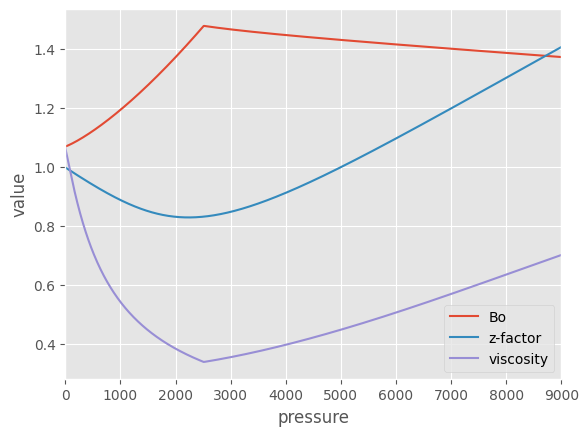

In [7]:
(
    pvt_oil.plot(x="pressure", y=["Bo", "z-factor", "viscosity"]).set(
        ylabel="value", xlim=(0, 9000)
    )
);

If pressure remains above the bubble point, then generate a `FlowProperties` instance, which becomes an argument passed to the `SinglePhaseReservoir` class. It's just like gas!

In [8]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 1_000) ** 2
flow_properties = FlowProperties(pvt_oil, p_i=8_500)
res_oil = SinglePhaseReservoir(60, 3000, 8500, flow_properties)

%time res_oil.simulate(time)
rf = res_oil.recovery_factor()

CPU times: user 4.19 s, sys: 0 ns, total: 4.19 s
Wall time: 4.2 s


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovered gas'),
 (0.0, 1.151535748608459),
 None,
 (0.0, 10.500000000000002)]

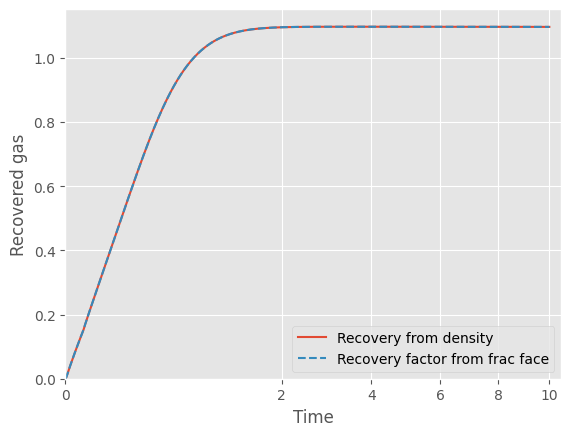

In [10]:
from scipy import interpolate


def resource_left(reservoir):
    pvt = reservoir.fluid.pvt_props
    density = interpolate.interp1d(pvt["m-scaled"], pvt["density"])
    mass = density(reservoir.pseudopressure).sum(axis=1) / reservoir.nx
    return mass / mass[0]


remaining_gas = resource_left(res_oil)

fig, ax = plt.subplots()
ax.plot(time, res_oil.recovery_factor(True), label="Recovery from density")
ax.plot(time, rf, "--", label="Recovery factor from frac face")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovered gas",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
)

# fig, ax = plt.subplots()
# ax.plot([min(remaining_gas), 1], [1 - min(remaining_gas), 0], label="Theory")
# ax.plot(remaining_gas, rf, "--", label="from checking at the frac face")
# ax.set(xlabel="Resource left", ylabel="Recovery factor", xlim=(0, 1), ylim=(0, 1))
# ax.legend()

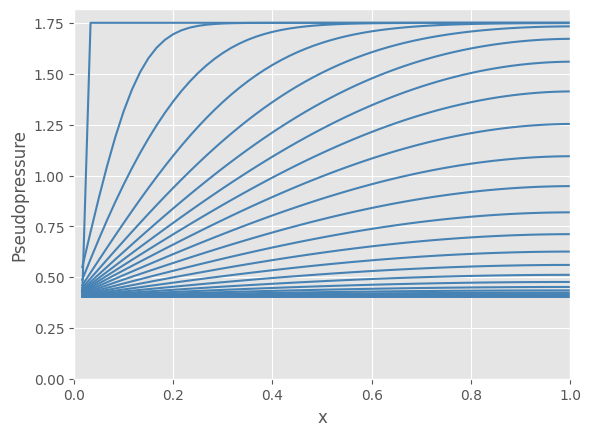

In [11]:
ax = plot_pseudopressure(res_oil, 20)

## Multiphase flow

In most cases, two phases are necessary to model tight oil wells. There is a gas phase that, at lower pressures, is no longer miscible with the oil phase. Water can also be present.

### Set up PVT

First we gather pvt data for the oil-gas system and water. Then we calculate the oil saturation as a function of pressure and perform the pseudopressure transform.

[(1000.0, 6000.0), (0.0, 1.0), Text(0, 0.5, 'Value')]

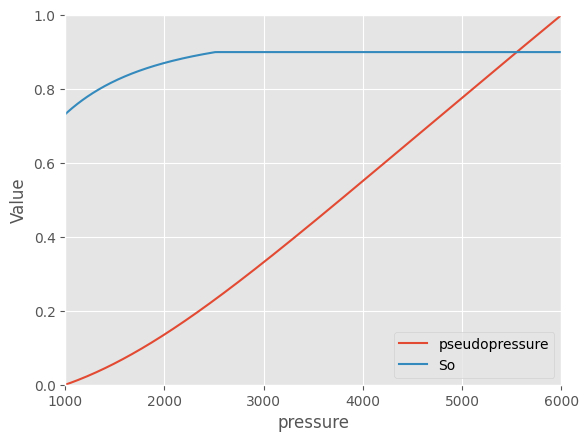

In [11]:
# set conditions
Sw = 0.1
p_frac = 1000
p_res = 6_000
phi = 0.1

# get pvt tables
pvt_oil = pd.read_csv("../tests/data/pvt_oil.csv")
pvt_water = pd.read_csv("../tests/data/pvt_water.csv").rename(
    columns={"T": "temperature", "P": "pressure", "Viscosity": "mu_w"}
)
df_pvt = (
    pvt_water.drop(columns=["temperature"])
    .merge(
        pvt_oil.rename(
            columns={
                "T": "temperature",
                "P": "pressure",
                "Oil_Viscosity": "mu_o",
                "Gas_Viscosity": "mu_g",
                "Rso": "Rs",
            }
        ),
        on="pressure",
    )
    .assign(Rv=0)
)

# calculate So, Sg assuming no mobile water
df_pvt_mp = df_pvt.copy()
df_pvt_mp["So"] = (1 - Sw) / (
    (df_pvt["Rs"].max() - df_pvt["Rs"]) * df_pvt["Bg"] / df_pvt["Bo"] / 5.61458 + 1
)

# scale pseudopressure
pseudopressure = interp1d(df_pvt.pressure, df_pvt.pseudopressure)
df_pvt_mp["pseudopressure"] = (
    pseudopressure(df_pvt_mp["pressure"]) - pseudopressure(p_frac)
) / (pseudopressure(p_res) - pseudopressure(p_frac))

fig, ax = plt.subplots()
df_pvt_mp.plot(x="pressure", y="pseudopressure", ax=ax)
df_pvt_mp.plot(x="pressure", y="So", ax=ax)
ax.set(xlim=(p_frac, p_res), ylim=(0, 1.0), ylabel="Value")

### Set up relative permeabilities

The next step involves declaring relative permeability curves. Here, we use the Brooks-Corey method, made available in this library with the `relative_permeabilities` function.

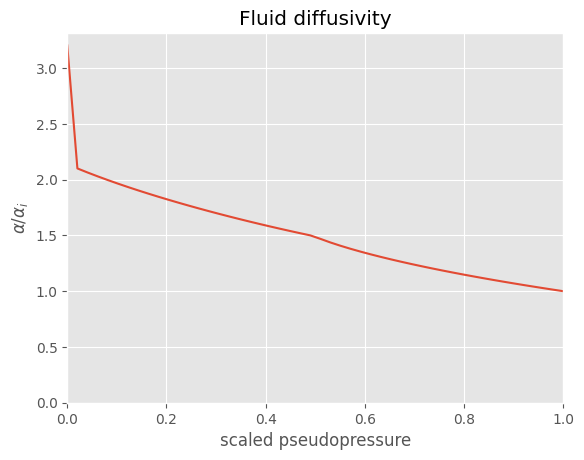

In [12]:
relperm_params = RelPermParams(
    n_o=1, n_g=1, n_w=1, S_or=0, S_gc=0, S_wc=0.1, k_ro_max=1, k_rw_max=1, k_rg_max=1
)
saturations_test = pd.DataFrame(
    {"So": np.linspace(0, 0.9), "Sw": np.full(50, 0.1), "Sg": np.linspace(0.9, 0)}
)
kr_matrix = pd.DataFrame(
    relative_permeabilities(saturations_test.to_records(index=False), relperm_params)
)
df_kr = pd.concat([saturations_test, kr_matrix], axis=1)
reference_densities = {"rho_o0": 141.5 / (45 + 131.5), "rho_g0": 1.03e-3, "rho_w0": 1}
flow_props = FlowPropertiesTwoPhase.from_table(
    df_pvt_mp, df_kr, reference_densities, phi, Sw, p_res
)
m_scaled = np.linspace(0, 1)
fig, ax = plt.subplots()
ax.plot(m_scaled, flow_props.alpha(m_scaled) / flow_props.alpha(1))
ax.set(
    xlim=(0, 1),
    ylim=(0, None),
    xlabel="scaled pseudopressure",
    ylabel=r"$\alpha/\alpha_i$",
    title="Fluid diffusivity",
);

### Simulate

Calculating the pseudopressure profiles and recovery factor looks very similar to the functions used above. The main difference is a more complicated `flow_props` that came from `FlowPropertiesTwoPhase`.

In [13]:
res = SinglePhaseReservoir(50, p_frac, p_res, flow_props)
t_end = 3
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res.simulate(time)
rf = res.recovery_factor()

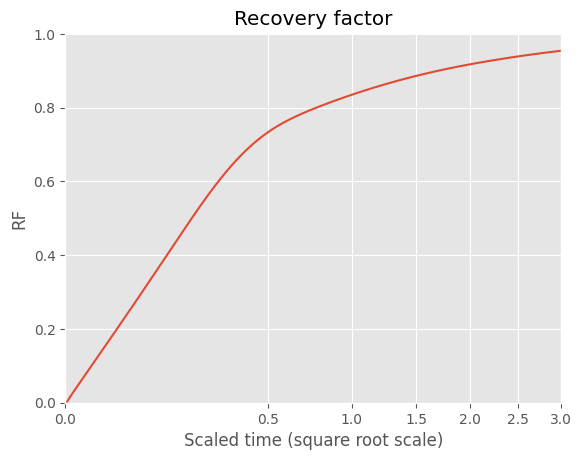

In [14]:
fig, ax = plt.subplots()
ax.plot(time, rf)
ax.set(
    xscale="squareroot",
    xlim=(0, t_end),
    ylim=(0, None),
    ylabel="RF",
    title="Recovery factor",
    xlabel="Scaled time (square root scale)",
);

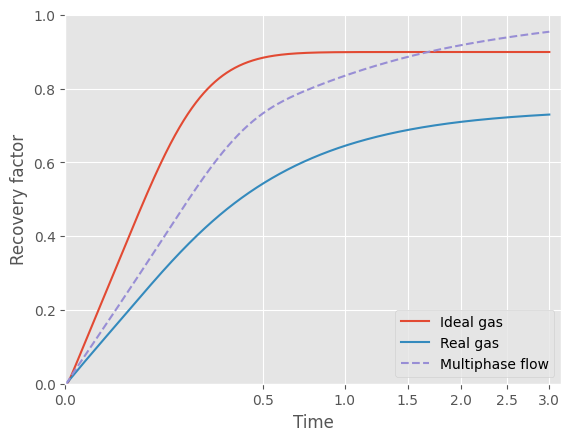

In [16]:
fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.plot(time, rf, "--", label="Multiphase flow")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovery factor",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
);